# Fisher's Exact Test to determine GO Term Enrichment of Probes

In [1]:
#Boilerplate Import 
import sys
sys.path.append('..')
import os
from itertools import chain
from collections import defaultdict
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import utils
from scripts.analysis import build_loci

In [2]:
pd.set_option('precision', 3)

In [3]:
BASE = '../data'

grouped_loci = utils.load(os.path.join(BASE,"grouped_loci_filt1.pkl.gz"))

In [4]:
import gseapy as gp
import goatools

obodag = goatools.obo_parser.GODag('go-basic.obo')

load obo file go-basic.obo
go-basic.obo: fmt(1.2) rel(2016-07-16) 46,953 GO Terms


In [5]:
def make_go2Gene_map(grouped_loci, ontology='MF'):
    ontology_map = {'MF': 'molecular_function', 'BP': 'biological_process', 'CC': 'cellular_component'}
    
    out = defaultdict(set)    
    for l in grouped_loci:
        if 'go' in l.annotations:
            for go in l.annotations['go']:
                if obodag[go].namespace == ontology_map[ontology]:
                    out[go].add(l.cluster_id)
                    for parent in obodag[go].get_all_parents():
                        if obodag[parent].namespace == ontology_map[ontology]:
                            out[parent].add(l.cluster_id)
                
    return out

In [6]:
def filter_go2gene_map(go_locus):
    
    # Remove "very broad" gene sets. Arbitrary definition: gene sets that emcompass >50% of all IDs
    all_ids = set(chain(*go_locus.values()))
    go_locus = {key: value for (key, value) in go_locus.items() if len(value) / len(all_ids) <= 0.5}

    # Remove terms with less than 10 members: 
    go_locus = {key: value for (key, value) in go_locus.items() if len(value) >= 10}

    # Remove child terms with identical gene sets as their parents
    to_remove = set()
    for parent in go_locus.keys():
        # If child term has exact same members as parent, remove
        child_ids = [x.id for x in obodag[parent].children if x.id in go_locus.keys()]
        for child in child_ids:
            if go_locus[child] == go_locus[parent]:
                to_remove.add(child)
    go_locus = {key: value for (key, value) in go_locus.items() if key not in to_remove}

    # Remove sibling terms with identical gene sets
    to_remove = set()
    for brother in go_locus.keys():
        for parent in obodag[brother].parents:
            siblings = set([y.id for y in parent.children])
            siblings.remove(brother)
            for sibling in siblings:
                if sibling in go_locus.keys() and go_locus[brother] == go_locus[sibling]:
                    to_remove.add(sibling)
    go_locus = {key: value for (key, value) in go_locus.items() if key not in to_remove}

    return go_locus

In [7]:
# pop is group1 + group2
def enrichment_fish(go_in_group, nongo_in_group, go_in_other, nongo_in_other):
    import scipy.stats as stats
        
    if go_in_group != 0:
        go_in_group -= 1
       
    oddsr, pval = stats.fisher_exact([[go_in_group, go_in_other], [nongo_in_group, nongo_in_other]], alternative='two-sided')
    
    samplings = go_in_group + nongo_in_group
    total_go = go_in_group + go_in_other
    total = go_in_group + nongo_in_group + go_in_other + nongo_in_other

    lower, expected = stats.hypergeom.interval(.99, M=total+1, n=total_go+1, N=samplings+1)
    
    return oddsr, pval, expected

In [8]:
group_df = pd.read_csv(os.path.join(BASE,'groups.csv'), index_col=0)
group_df.head()

,RAG_Enriched,RAG_Unenriched,RT_Enriched,RT_Unenriched
115324,True,False,True,False
132035,False,True,False,False
318873,False,True,False,True
376417,False,False,True,True
585756,False,True,False,False


In [9]:
mf_map = filter_go2gene_map(make_go2Gene_map(grouped_loci))
bp_map = filter_go2gene_map(make_go2Gene_map(grouped_loci, ontology='BP'))
cc_map = filter_go2gene_map(make_go2Gene_map(grouped_loci, ontology='CC'))

In [10]:
def enrichment_df(group1, group2, go_map):
    pv = dict()

    all_annotations = set(go_map.keys())
    
    group_loci = set(group_df.query('{} and ~{}'.format(group1, group2)).index)
    other_loci = set(group_df.query('~({} and ~{})'.format(group1, group2)).index)

    for annotation in all_annotations:
        go_in_group = len(go_map[annotation] & group_loci)
        nongo_in_group = len(group_loci) - go_in_group
        go_in_other =  len(go_map[annotation] & other_loci)
        nongo_in_other = len(other_loci) - go_in_other

        odds_r, p_val, expected = enrichment_fish(go_in_group, nongo_in_group, go_in_other, nongo_in_other)

        pv[annotation] = [obodag[annotation].name, odds_r, p_val, go_in_group+go_in_other, go_in_group, expected]

    res = (pd.DataFrame(pv)
             .T
             .rename(columns={0: 'name', 1:'odds_ratio', 2:'p_value', 3: 'total_annot', 4:'in_group', 5:'expected'})
             .sort_values(by=['p_value']))
    return res

## RT - Enriched vs Uneneriched - MF

In [11]:
(enrichment_df('RT_Enriched', 'RT_Unenriched', mf_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,name,odds_ratio,p_value,total_annot,in_group,expected
GO:0008234,cysteine-type peptidase activity,14.9,3.93e-09,25,21,12
GO:0016153,urocanate hydratase activity,14.8,4.26e-05,13,11,8
GO:0004197,cysteine-type endopeptidase activity,8.89,4.37e-05,17,13,9
GO:0004022,alcohol dehydrogenase (NAD) activity,8.15,0.000131,16,12,9
GO:0004825,methionine-tRNA ligase activity,7.88,0.00131,12,9,7
GO:0008774,acetaldehyde dehydrogenase (acetylating) activity,7.4,0.000385,15,11,8
GO:0016879,"ligase activity, forming carbon-nitrogen bonds",3.82,0.00027,33,19,15
GO:0016810,"hydrolase activity, acting on carbon-nitrogen ...",3.41,8.14e-05,46,25,20
GO:0004177,aminopeptidase activity,3.25,0.00927,22,12,11
GO:0016620,"oxidoreductase activity, acting on the aldehyd...",3.21,5.7e-11,140,72,49


## RT - Enriched vs Uneneriched - BP

In [12]:
(enrichment_df('RT_Enriched', 'RT_Unenriched', bp_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,name,odds_ratio,p_value,total_annot,in_group,expected
GO:0006431,methionyl-tRNA aminoacylation,7.88,0.00131,12,9,7
GO:0015976,carbon utilization,7.4,0.000385,15,11,8
GO:0042026,protein refolding,3.3,0.000476,39,21,17
GO:0034660,ncRNA metabolic process,2.49,0.00987,36,17,16
GO:0006520,cellular amino acid metabolic process,2.45,1.03e-13,329,144,104
GO:0006508,proteolysis,2.28,0.000176,96,42,36
GO:0006457,protein folding,2.13,0.0075,56,24,23


## RT - Unenriched vs Enriched - MF

In [13]:
(enrichment_df('RT_Unenriched', 'RT_Enriched', mf_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,name,odds_ratio,p_value,total_annot,in_group,expected
GO:0004619,phosphoglycerate mutase activity,9.6,1.97e-09,45,40,29
GO:0008982,protein-N(PI)-phosphohistidine-sugar phosphotr...,8.52,0.000658,17,15,13
GO:0004540,ribonuclease activity,7.91,0.00128,16,14,12
GO:0016796,"exonuclease activity, active with either ribo-...",7.91,0.00128,16,14,12
GO:0034062,RNA polymerase activity,7.18,8.97e-22,134,114,75
GO:0003677,DNA binding,6.15,1.75e-20,141,117,79
GO:0016868,"intramolecular transferase activity, phosphotr...",6.05,2.57e-09,60,50,37
GO:0004654,polyribonucleotide nucleotidyltransferase acti...,5.79,0.000441,24,20,17
GO:1901476,carbohydrate transporter activity,5.68,0.00249,18,15,14
GO:0005198,structural molecule activity,5.58,1.63e-40,319,257,167


## RT - Unenriched vs Enriched - BP

In [14]:
(enrichment_df('RT_Unenriched', 'RT_Enriched', bp_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,name,odds_ratio,p_value,total_annot,in_group,expected
GO:0006928,movement of cell or subcellular component,72.4,4.34e-37,116,114,66
GO:0040011,locomotion,72.4,4.34e-37,116,114,66
GO:0010468,regulation of gene expression,23.2,3.13e-06,21,20,15
GO:0019222,regulation of metabolic process,7.73,0.000112,23,20,17
GO:0032774,RNA biosynthetic process,7.32,2.58e-22,136,116,76
GO:0097659,nucleic acid-templated transcription,7.18,8.97e-22,134,114,75
GO:0043604,amide biosynthetic process,5.44,4.03e-23,179,145,98
GO:0006518,peptide metabolic process,5.29,7.7e-23,180,145,98
GO:0006396,RNA processing,5.27,0.00453,17,14,13
GO:0043603,cellular amide metabolic process,5.21,7.12e-23,183,147,100


## RAG - Enriched vs Unenriched - MF

In [15]:
(enrichment_df('RAG_Enriched', 'RAG_Unenriched', mf_map)
 .query('odds_ratio > 1 and p_value < 0.01')
 .sort_values('odds_ratio', ascending=False))

,name,odds_ratio,p_value,total_annot,in_group,expected
GO:0016153,urocanate hydratase activity,19.2,6.55e-06,13,11,7
GO:0004022,alcohol dehydrogenase (NAD) activity,10.5,1.84e-05,16,12,8
GO:0004825,methionine-tRNA ligase activity,10.2,0.000315,12,9,6
GO:0008774,acetaldehyde dehydrogenase (acetylating) activity,9.57,6.57e-05,15,11,8
GO:0008234,cysteine-type peptidase activity,9.36,1.84e-07,25,18,11
GO:0004197,cysteine-type endopeptidase activity,6.38,0.000348,17,11,8
GO:0016620,"oxidoreductase activity, acting on the aldehyd...",4.47,5.37e-17,140,74,42
GO:0016811,"hydrolase activity, acting on carbon-nitrogen ...",3.06,0.00662,28,13,12
GO:0016879,"ligase activity, forming carbon-nitrogen bonds",2.98,0.00341,33,15,13
GO:0016638,"oxidoreductase activity, acting on the CH-NH2 ...",2.85,2.35e-07,115,49,36


## RAG - Enriched vs Unenriched - BP

In [16]:
(enrichment_df('RAG_Enriched', 'RAG_Unenriched', bp_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,name,odds_ratio,p_value,total_annot,in_group,expected
GO:0006431,methionyl-tRNA aminoacylation,10.2,0.000315,12,9,6
GO:0015976,carbon utilization,9.57,6.57e-05,15,11,8
GO:0006730,one-carbon metabolic process,5.72,0.00786,11,7,6
GO:0042026,protein refolding,4.28,1.42e-05,39,21,15
GO:0006457,protein folding,3.22,3.59e-05,56,26,20
GO:0006066,alcohol metabolic process,2.79,0.00384,39,17,15
GO:0006520,cellular amino acid metabolic process,2.69,2.02e-15,329,130,87
GO:1901615,organic hydroxy compound metabolic process,2.67,0.00444,40,17,15


## RAG - Unenriched vs Enriched - MF

In [17]:
(enrichment_df('RAG_Unenriched', 'RAG_Enriched', mf_map)
 .query('odds_ratio > 1 and p_value < 0.001 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,name,odds_ratio,p_value,total_annot,in_group,expected
GO:0044769,"ATPase activity, coupled to transmembrane move...",26,2.46e-12,40,38,25
GO:0004540,ribonuclease activity,19.5,4.73e-05,16,15,12
GO:0016796,"exonuclease activity, active with either ribo-...",19.5,4.73e-05,16,15,12
GO:0004619,phosphoglycerate mutase activity,19.3,7.74e-13,45,42,27
GO:0015078,hydrogen ion transmembrane transporter activity,17.8,8.74e-12,42,39,26
GO:0022890,inorganic cation transmembrane transporter act...,11,1.64e-10,45,40,27
GO:0022853,active ion transmembrane transporter activity,10.7,3.38e-10,44,39,27
GO:0008324,cation transmembrane transporter activity,9.39,2.9e-10,47,41,28
GO:0042623,"ATPase activity, coupled",9.39,2.9e-10,47,41,28
GO:0004654,polyribonucleotide nucleotidyltransferase acti...,9.29,1.42e-05,24,21,16


## RAG - Unenriched vs Enriched - BP

In [18]:
(enrichment_df('RAG_Unenriched', 'RAG_Enriched', bp_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,name,odds_ratio,p_value,total_annot,in_group,expected
GO:0040011,locomotion,40.7,1.91e-37,116,112,62
GO:0006928,movement of cell or subcellular component,40.7,1.91e-37,116,112,62
GO:0015985,"energy coupled proton transport, down electroc...",27.5,4.68e-13,42,40,26
GO:0009142,nucleoside triphosphate biosynthetic process,14.1,1.14e-11,45,41,27
GO:0006754,ATP biosynthetic process,13.7,2.5e-11,44,40,27
GO:1901361,organic cyclic compound catabolic process,10.2,3.56e-06,26,23,17
GO:0034220,ion transmembrane transport,9.9,1.51e-12,57,50,34
GO:0006396,RNA processing,9.73,0.000392,17,15,12
GO:0006818,hydrogen transport,9.2,8.94e-13,61,53,36
GO:0090662,ATP hydrolysis coupled transmembrane transport,8.67,4.44e-09,44,38,27


## Both - Unenriched vs Enriched - MF

In [19]:
res = (enrichment_df('(RAG_Unenriched or RT_Unenriched)', '(RT_Enriched or RAG_Enriched)', mf_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))
res.to_csv(os.path.join(BASE, 'unenr_mf.csv'))
res

,name,odds_ratio,p_value,total_annot,in_group,expected
GO:0044769,"ATPase activity, coupled to transmembrane move...",21.1,1.67e-10,40,38,27
GO:0008982,protein-N(PI)-phosphohistidine-sugar phosphotr...,16.9,0.000146,17,16,13
GO:0015078,hydrogen ion transmembrane transporter activity,14.4,7.06e-10,42,39,28
GO:0046992,"oxidoreductase activity, acting on X-H and Y-H...",11.3,0.00427,12,11,10
GO:0022890,inorganic cation transmembrane transporter act...,8.89,1.37e-08,45,40,30
GO:0004619,phosphoglycerate mutase activity,8.89,1.37e-08,45,40,30
GO:0022853,active ion transmembrane transporter activity,8.66,2.54e-08,44,39,29
GO:1901476,carbohydrate transporter activity,8.46,0.000836,18,16,14
GO:0008324,cation transmembrane transporter activity,7.6,1.93e-08,47,41,31
GO:0042623,"ATPase activity, coupled",7.6,1.93e-08,47,41,31


## Both - Enriched vs Unenriched - MF

In [20]:
res = (enrichment_df('(RT_Enriched or RAG_Enriched)', '(RAG_Unenriched or RT_Unenriched)', mf_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))
res.to_csv(os.path.join(BASE, 'enr_mf.csv'))
res

,name,odds_ratio,p_value,total_annot,in_group,expected
GO:0008234,cysteine-type peptidase activity,14.8,4.65e-09,25,21,12
GO:0016153,urocanate hydratase activity,14.6,4.63e-05,13,11,8
GO:0004197,cysteine-type endopeptidase activity,8.79,4.81e-05,17,13,9
GO:0004022,alcohol dehydrogenase (NAD) activity,8.05,0.000143,16,12,9
GO:0004825,methionine-tRNA ligase activity,7.79,0.0014,12,9,7
GO:0008774,acetaldehyde dehydrogenase (acetylating) activity,7.31,0.000416,15,11,8
GO:0016879,"ligase activity, forming carbon-nitrogen bonds",3.78,0.000287,33,19,15
GO:0016810,"hydrolase activity, acting on carbon-nitrogen ...",3.69,1.85e-05,46,26,20
GO:0016811,"hydrolase activity, acting on carbon-nitrogen ...",3.66,0.00119,28,16,13
GO:0004177,aminopeptidase activity,3.21,0.00967,22,12,11


# Both Enriched vs Unenriched - BP

In [21]:
res = (enrichment_df('(RT_Enriched or RAG_Enriched)', '(RAG_Unenriched or RT_Unenriched)', bp_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))
res.to_csv(os.path.join(BASE, 'enr_bp.csv'))
res

,name,odds_ratio,p_value,total_annot,in_group,expected
GO:0006431,methionyl-tRNA aminoacylation,7.79,0.0014,12,9,7
GO:0015976,carbon utilization,7.31,0.000416,15,11,8
GO:0042026,protein refolding,3.26,0.000495,39,21,17
GO:0006520,cellular amino acid metabolic process,2.42,2.08e-13,329,144,104
GO:0006508,proteolysis,2.25,0.000189,96,42,36
GO:0006457,protein folding,2.11,0.00795,56,24,23


# Both - Unenriched vs Enriched - BP

In [22]:
pd.options.display.max_rows = 999

In [23]:
res = (enrichment_df('(RAG_Unenriched or RT_Unenriched)', '(RT_Enriched or RAG_Enriched)', bp_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))
res.to_csv(os.path.join(BASE, 'unenr_bp.csv'))
res

In [24]:
res = (enrichment_df('(RT_Enriched or RAG_Enriched)', '(RAG_Unenriched or RT_Unenriched)', cc_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))
res.to_csv(os.path.join(BASE, 'enr_cc.csv'))
res

,name,odds_ratio,p_value,total_annot,in_group,expected
GO:0005737,cytoplasm,1.57,0.00506,192,67,65


In [25]:
res = (enrichment_df('(RAG_Unenriched or RT_Unenriched)', '(RT_Enriched or RAG_Enriched)', cc_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))
res.to_csv(os.path.join(BASE, 'unenr_cc.csv'))
res

,name,odds_ratio,p_value,total_annot,in_group,expected
GO:0042995,cell projection,inf,5.09e-39,116,116,68
GO:0044463,cell projection part,inf,5.31e-38,113,113,67
GO:0033178,"proton-transporting two-sector ATPase complex,...",22.8,2.01e-11,43,41,29
GO:0015934,large ribosomal subunit,13.6,1.39e-06,27,25,19
GO:0044391,ribosomal subunit,12.4,7.1e-20,94,86,57
GO:0015935,small ribosomal subunit,11.5,5.06e-14,67,61,42
GO:0043228,non-membrane-bounded organelle,10.1,6.97e-48,257,229,141
GO:0043226,organelle,9.82,1.96e-47,259,230,142
GO:0044422,organelle part,7.25,3.13e-37,243,208,134
GO:1990904,ribonucleoprotein complex,6.25,6.33e-24,170,143,97


## Diagram of Differences

In [26]:
group1 = '(RAG_Unenriched or RT_Unenriched)'
group2 = '(RT_Enriched or RAG_Enriched)'

unenr_loci = set(group_df.query('{}'.format(group1)).index)
enr_loci = set(group_df.query('{}'.format(group2)).index)

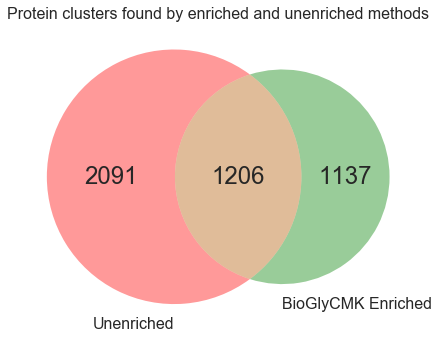

In [27]:
from matplotlib_venn import venn2
fig, ax = plt.subplots(1,1)
fig.set_tight_layout(False)

v = venn2([unenr_loci, enr_loci], ['Unenriched', 'BioGlyCMK Enriched'])

for txt in v.set_labels:
    txt.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(24)
plt.title('Protein clusters found by enriched and unenriched methods', size = 16)

plt.savefig(os.path.join(BASE, 'enr_v_unenr.svg'), dpi = 100);